# LHII Dimers

In [1]:
import re
import glob
import json
import pickle
import numpy as np
import pandas as pd

pd.set_option('display.max_columns', 100000)  # or 1000
pd.set_option('display.max_rows', 1000)  # or 1000
pd.set_option('display.max_colwidth', 100000)  # or 199

import matplotlib.pyplot as plt

import matplotlib
matplotlib.rcParams.update({"font.size" : 22})

import read_gaussian

In [2]:
def get_centre(file_name):
    lines = list(open(file_name))
    
    for line in lines:
        if "Mg" in line:
            return 1.88973 * np.array([float(x) for x in re.findall(r'-?\d+.\d+', line)])

def read_exciton_file(file):
    eigenvalues = []
    coupling = None
    distance = None
    
    with open(file) as f:
        lines = f.readlines()    
    
    for enum, line in enumerate(lines):
        if "eigenvalues" in line:
            eigenvalues = [float(x[0]) for x in [re.findall(r'-?\d+.\d+', line) for line in lines[enum+2:enum+5]]]
            
        if "coupling energies" in line:
            coupling = float(re.findall(r'-?\d+.\d+', lines[enum+2])[0])
            
        if "distances" in line:
            distance = float(re.findall(r'-?\d+.\d+', lines[enum+2])[0])
            
    return eigenvalues, coupling, distance
        
def read_bchla_xtb(i, j, frame, file):
    monomerA = f"monomer_xyzs/trunc_bchla_{i}_frame_{frame}.xyz"
    monomerB = f"monomer_xyzs/trunc_bchla_{j}_frame_{frame}.xyz"
    
    centreA = get_centre(monomerA)
    centreB = get_centre(monomerB)
    
    distance = np.linalg.norm(centreA - centreB)
    
    eigenvalues, coupling, charge_centre_distance = read_exciton_file(file)
    
    return distance, eigenvalues, coupling, charge_centre_distance

def make_results_df():
    ring_assingments = json.load(open("ring_assignment.json"))
    assign_ring = lambda i : ring_assingments["rings"][f"{i}"]
    
    monomerAs = []
    monomerBs = []
    ringAs = []
    ringBs = []
    frames = []
    
    distances = []
    charge_centre_distances = []
    
    bchla_xtb_states = []
    bchla_xtb_transitions= []
    
    couplings = []

    CAMB3LYP_states = []
    CAMB3LYP_transitions = []
    
    for file in glob.glob("Exciton_Bchla_xTB/*.out"):
        ints = [int(x) for x in re.findall(r'\d+', file)]
        a, b = ints[:-1]
        frame = ints[2]
        
        if frame == 101:
            continue
        
        distance, eigenvalues, coupling, charge_centre_distance = read_bchla_xtb(a, b, frame, file)
        
        try:
            CAMB3LYP_results = read_gaussian.read_gaussian(f"CAMB3LYP/CAMB3LYP_trunc_bchla_{a}_bchla_{b}_frame_{frame}.log")

        except:
            CAMB3LYP_states.append([None, None, None])
            CAMB3LYP_transitions.append([None, None])
        else:
            CAMB3LYP_states.append([CAMB3LYP_results.total_energy, CAMB3LYP_results.state_energies[0], CAMB3LYP_results.state_energies[1]])
            CAMB3LYP_transitions.append(CAMB3LYP_results.excitations[0:2])

        distances.append(distance)
        charge_centre_distances.append(charge_centre_distance)
        
        bchla_xtb_states.append(eigenvalues)
        bchla_xtb_transitions.append([round(x - eigenvalues[0], 6) for x in eigenvalues[1:]])
        couplings.append(abs(coupling))
                
        monomerAs.append(a)
        monomerBs.append(b)
        ringAs.append(assign_ring(a))
        ringBs.append(assign_ring(b))
            
        frames.append(frame)
        
    CAMB3LYP_present = [x[0]!=None for x in CAMB3LYP_states]
        
    return pd.DataFrame.from_dict({
    "monomer A" : np.array(monomerAs),
    "monomer B" : np.array(monomerBs),
    "ring A" : ringAs,
    "ring B" : ringBs,
    "frame" : np.array(frames),
    "distance" : np.array(distances),
    "charge_centre_distance" : np.array(charge_centre_distances),
    "coupling" : couplings,
    "exciton states" : bchla_xtb_states,
    "exciton transitions" : bchla_xtb_transitions,
    "CAMB3LYP states" : CAMB3LYP_states,
    "CAMB3LYP transitions" : CAMB3LYP_transitions,
    "CAMB3LYP present" : CAMB3LYP_present
    })

In [3]:
def load_data():
    with open("Exciton/exciton_data.json") as d:
        data = json.load(d)
        
    CAMB3LYP_files = glob.glob("CAMB3LYP/*.com")
        
    CAMB3LYP_states = [[None, None, None] for i in range(len(data["monomer A"]))]
    CAMB3LYP_transitions = [[None, None] for i in range(len(data["monomer A"]))]
    CAMB3LYP_present = [False for i in range(len(data["monomer A"]))]
    
    for enum, (i, j, frame) in enumerate(zip(data["monomer A"], data["monomer B"], data["frame"])):
        for file in CAMB3LYP_files:
            if f"bchla_{i}_bchla_{j}_frame_{frame}.com" in file:
                CAMB3LYP_results = read_gaussian.read_gaussian(f"CAMB3LYP/CAMB3LYP_trunc_bchla_{i}_bchla_{j}_frame_{frame}.log")
                CAMB3LYP_states[enum] = [CAMB3LYP_results.total_energy, CAMB3LYP_results.state_energies[0], CAMB3LYP_results.state_energies[1]]
                CAMB3LYP_transitions[enum] = CAMB3LYP_results.excitations[0:2]
                CAMB3LYP_present[enum] = True
    
    data["CAMB3LYP states"] = CAMB3LYP_states
    data["CAMB3LYP transitions"] = CAMB3LYP_transitions
    data["CAMB3LYP present"] = CAMB3LYP_present
        
    return pd.DataFrame.from_dict(data)

In [4]:
full_LHII_dimers = load_data()

In [5]:
LHII_dimers = full_LHII_dimers.loc[full_LHII_dimers["CAMB3LYP present"]]
LHII_dimers = LHII_dimers.sort_values(by="distance")

In [6]:
def get_values(series, i):
    return np.array([x[i] for x in series])

def assign_transitions(df):
    #this is probably wrong
    
    camb3lyp_transitions = [get_values(LHII_dimers["CAMB3LYP transitions"], 0), get_values(LHII_dimers["CAMB3LYP transitions"], 1)]
    exciton_transitions  = [get_values(LHII_dimers["exciton transitions"], 0), get_values(LHII_dimers["exciton transitions"], 1)]
    
    distances = LHII_dimers["distance"].to_numpy()
    
    assigned_camb3lyp_transitions = []
    assigned_exciton_transitions = []
    all_distances = []
    
    for enum, trns in enumerate(camb3lyp_transitions[0]):
        
        same_index = abs(camb3lyp_transitions[0][enum] - exciton_transitions[0][enum]) + abs(camb3lyp_transitions[0][enum] - exciton_transitions[0][enum])
        opps_index = abs(camb3lyp_transitions[1][enum] - exciton_transitions[0][enum]) + abs(camb3lyp_transitions[0][enum] - exciton_transitions[1][enum])
        
        if(same_index < opps_index):
            assigned_camb3lyp_transitions.append(camb3lyp_transitions[0][enum])
            assigned_camb3lyp_transitions.append(camb3lyp_transitions[1][enum])
            
            assigned_exciton_transitions.append(exciton_transitions[0][enum])
            assigned_exciton_transitions.append(exciton_transitions[1][enum])
            
        elif(opps_index < same_index):
            print(round(camb3lyp_transitions[0][enum], 4), round(camb3lyp_transitions[1][enum], 4))
            print(exciton_transitions[0][enum], exciton_transitions[1][enum])
            print()
            
            assigned_camb3lyp_transitions.append(camb3lyp_transitions[0][enum])
            assigned_camb3lyp_transitions.append(camb3lyp_transitions[1][enum])
            
            assigned_exciton_transitions.append(exciton_transitions[1][enum])
            assigned_exciton_transitions.append(exciton_transitions[0][enum])
        
        all_distances.append(distances[enum])
        all_distances.append(distances[enum])
        
    assert(len(assigned_camb3lyp_transitions) == len(assigned_exciton_transitions))
    assert(len(assigned_camb3lyp_transitions) == len(all_distances))
    
    return assigned_camb3lyp_transitions, assigned_exciton_transitions, all_distances

## By Distance

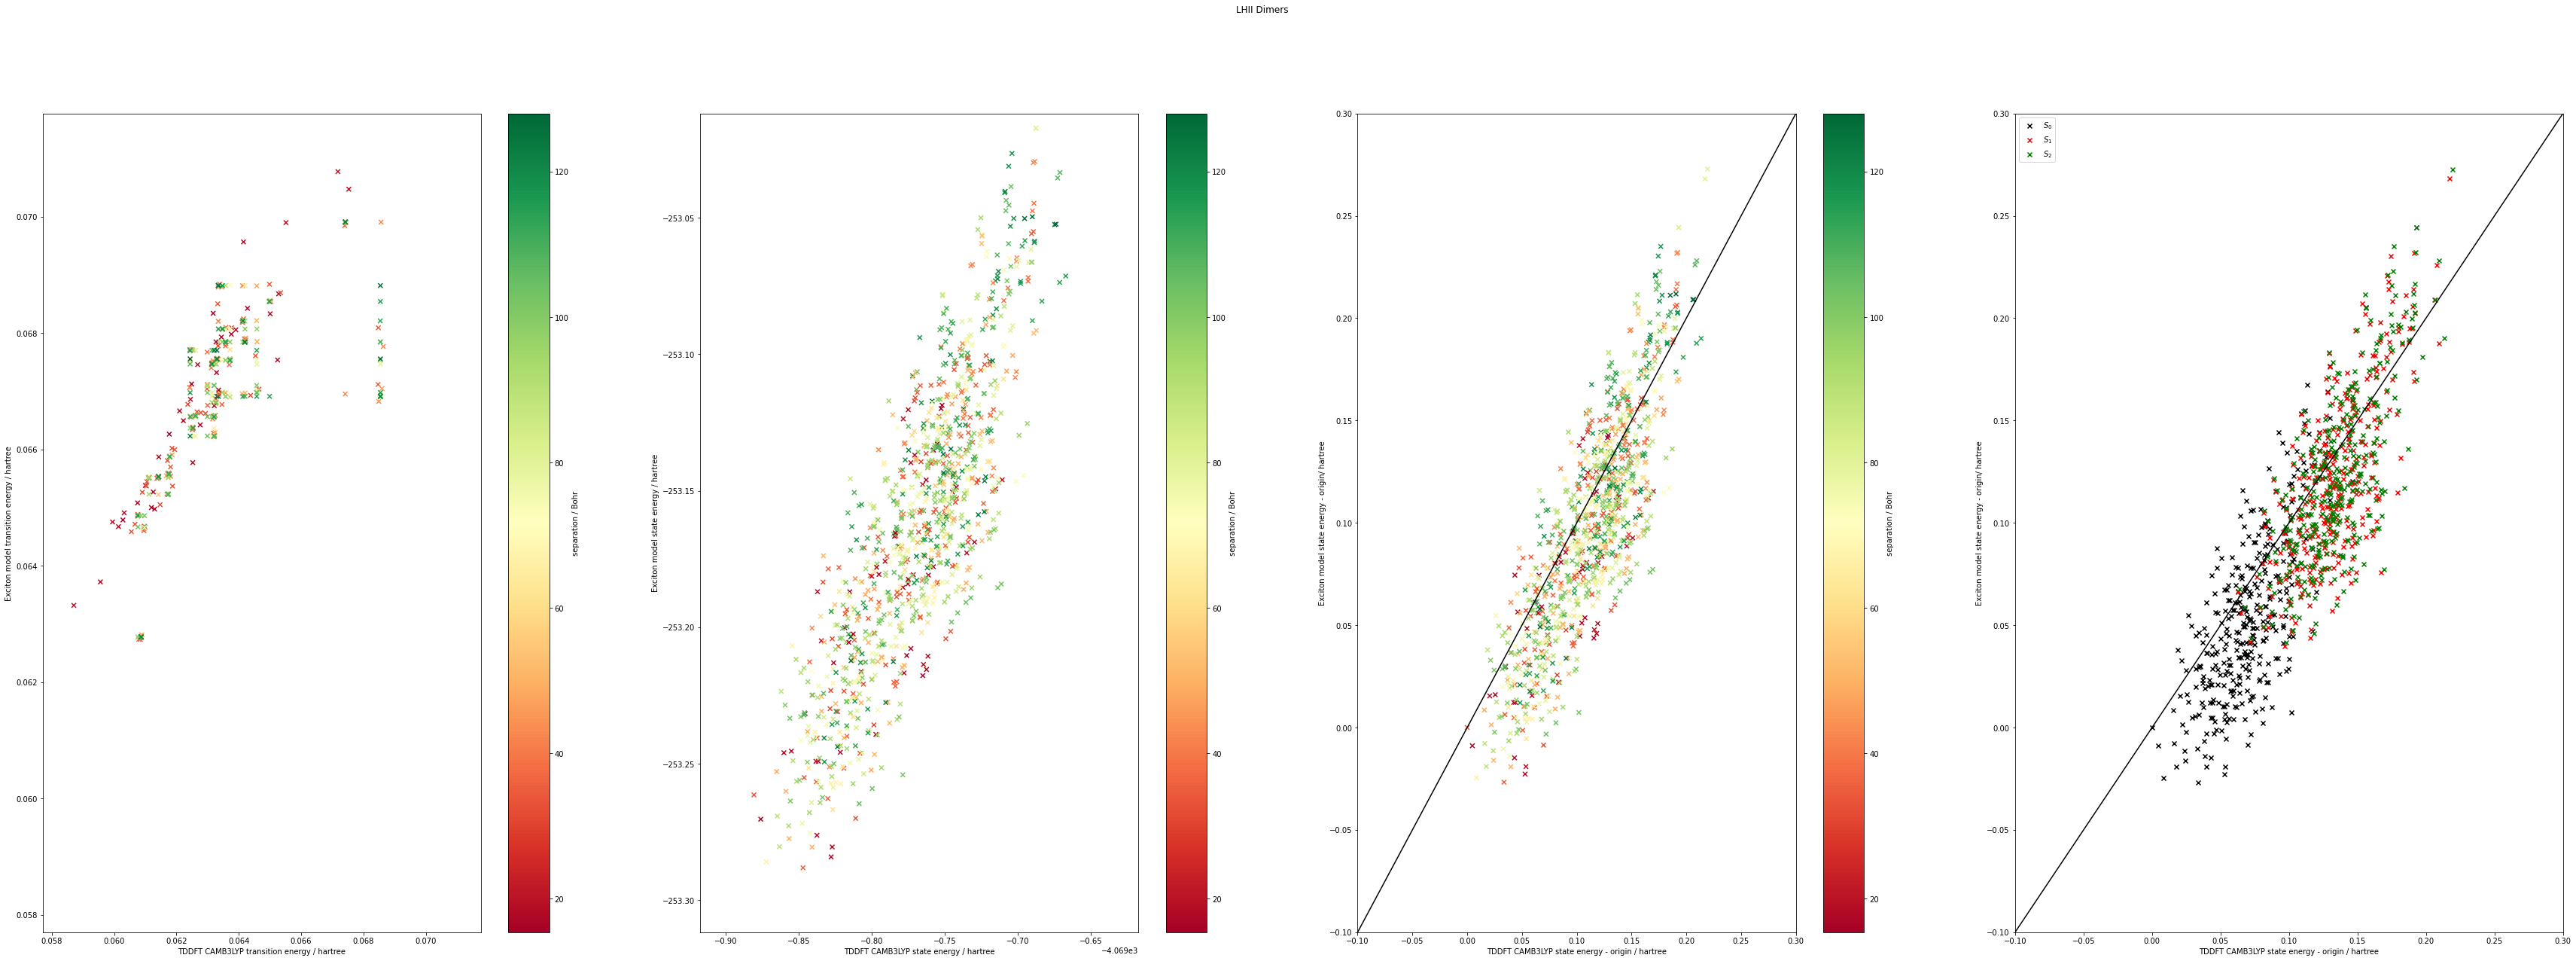

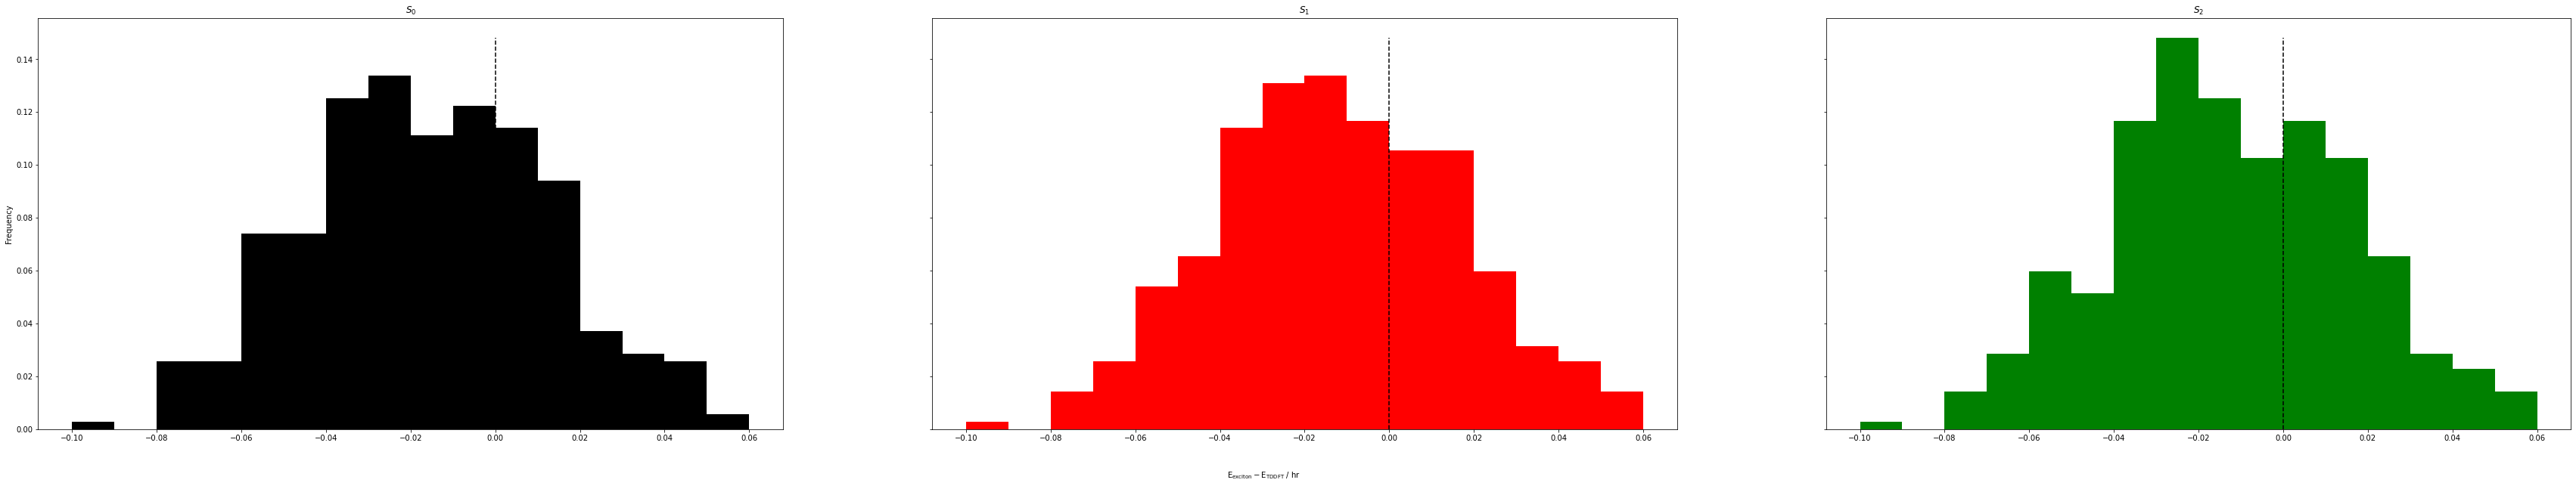

In [31]:
fig, ax = plt.subplots(1, 4)

CAMB3LYP_transition_1 = get_values(LHII_dimers["CAMB3LYP transitions"], 0)
CAMB3LYP_transition_2 = get_values(LHII_dimers["CAMB3LYP transitions"], 1)

exciton_transition_1 = get_values(LHII_dimers["exciton transition"], 0)
exciton_transition_2 = get_values(LHII_dimers["exciton transition"], 1)

CAMB3LYP_ground_state = get_values(LHII_dimers["CAMB3LYP states"], 0)
CAMB3LYP_excited1_state = get_values(LHII_dimers["CAMB3LYP states"], 1)
CAMB3LYP_excited2_state = get_values(LHII_dimers["CAMB3LYP states"], 2)

exciton_ground_state = get_values(LHII_dimers["exciton states"], 0)
exciton_excited1_state = get_values(LHII_dimers["exciton states"], 1)
exciton_excited2_state = get_values(LHII_dimers["exciton states"], 2)

camb3lyp_transitions = np.concatenate((CAMB3LYP_transition_1, CAMB3LYP_transition_2))
exciton_transitions  = np.concatenate((exciton_transition_1, exciton_transition_2))

camb3lyp_states = np.concatenate((CAMB3LYP_ground_state, CAMB3LYP_excited1_state, CAMB3LYP_excited2_state))
exciton_states = np.concatenate((exciton_ground_state, exciton_excited1_state, exciton_excited2_state))

min_index = np.argmin(CAMB3LYP_ground_state)

camb3lyp_origin = CAMB3LYP_ground_state[min_index]
exciton_origin = exciton_ground_state[min_index]

CAMB3LYP_ground_state_relative   = np.array([x - camb3lyp_origin for x in CAMB3LYP_ground_state])
CAMB3LYP_excited1_state_relative = np.array([x - camb3lyp_origin for x in CAMB3LYP_excited1_state])
CAMB3LYP_excited2_state_relative = np.array([x - camb3lyp_origin for x in CAMB3LYP_excited2_state])

exciton_ground_state_relative   = np.array([x - exciton_origin for x in exciton_ground_state])
exciton_excited1_state_relative = np.array([x - exciton_origin for x in exciton_excited1_state])
exciton_excited2_state_relative = np.array([x - exciton_origin for x in exciton_excited2_state])

camb3lyp_states_relative = np.concatenate((CAMB3LYP_ground_state_relative, CAMB3LYP_excited1_state_relative, CAMB3LYP_excited2_state_relative))
exciton_states_relative  = np.concatenate((exciton_ground_state_relative, exciton_excited1_state_relative, exciton_excited2_state_relative))

all_distances = np.concatenate((LHII_dimers["distance"], LHII_dimers["distance"]))
all_distances3 = np.concatenate((LHII_dimers["distance"], LHII_dimers["distance"], LHII_dimers["distance"]))

state_numbers = np.concatenate(([0 for x in range(len(CAMB3LYP_ground_state_relative))], [1 for x in range(len(CAMB3LYP_excited1_state_relative))], [2 for x in range(len(CAMB3LYP_excited2_state_relative))]))

cax_transition = ax[0].scatter(camb3lyp_transitions, exciton_transitions,  c=all_distances, cmap='RdYlGn', marker='x')
cax_states = ax[1].scatter(camb3lyp_states, exciton_states,  c=all_distances3, cmap='RdYlGn', marker='x')
cax_relative = ax[2].scatter(camb3lyp_states_relative, exciton_states_relative, c=all_distances3, cmap='RdYlGn', marker='x')

ax[3].scatter(CAMB3LYP_ground_state_relative, exciton_ground_state_relative, marker='x', color='black', label="$S_0$")
ax[3].scatter(CAMB3LYP_excited1_state_relative, exciton_excited1_state_relative, marker='x', color='red', label="$S_1$")
ax[3].scatter(CAMB3LYP_excited2_state_relative, exciton_excited2_state_relative, marker='x', color='green', label="$S_2$")

max_transition = max(max(camb3lyp_transitions), max(exciton_transitions))
min_transition = min(min(camb3lyp_transitions), min(exciton_transitions))
padding = 0.001

ax[0].set_xlim(min_transition - padding, max_transition + padding)
ax[0].set_ylim(min_transition - padding, max_transition + padding)

exciton_average = np.mean(camb3lyp_states)
camb3lyp_average = np.mean(exciton_states)

ax[1].set_ylim(camb3lyp_average-0.15, camb3lyp_average+0.15)
ax[1].set_xlim(exciton_average-0.15, exciton_average+0.15)


rel_min = -.1
rel_max = 0.3

ax[2].plot([rel_min, rel_max], [rel_min, rel_max], color='black')
ax[2].set_xlim(rel_min, rel_max)
ax[2].set_ylim(rel_min, rel_max)

ax[3].plot([rel_min, rel_max], [rel_min, rel_max], color='black')
ax[3].set_xlim(rel_min, rel_max)
ax[3].set_ylim(rel_min, rel_max)

#p = np.polyfit(camb3lyp_transitions, exciton_transitions, deg=1)

#line_of_best_fit = lambda x : p[0] * x + p[1]

#ax[0].plot([min_transition, max_transition], [line_of_best_fit(x) for x in [min_transition-padding, max_transition+padding]], color='black')

ax[0].set_xlabel("TDDFT CAMB3LYP transition energy / hartree")
ax[0].set_ylabel("Exciton model transition energy / hartree")

ax[1].set_xlabel("TDDFT CAMB3LYP state energy / hartree")
ax[1].set_ylabel("Exciton model state energy / hartree")

ax[2].set_xlabel("TDDFT CAMB3LYP state energy - origin / hartree")
ax[2].set_ylabel("Exciton model state energy - origin/ hartree")

ax[3].set_xlabel("TDDFT CAMB3LYP state energy - origin / hartree")
ax[3].set_ylabel("Exciton model state energy - origin/ hartree")
ax[3].legend()

cbar_transition = fig.colorbar(cax_transition, ax=ax[0])
cbar_transition.set_label("separation / Bohr")

cbar_states = fig.colorbar(cax_states, ax=ax[1])
cbar_states.set_label("separation / Bohr")

cbar_relative = fig.colorbar(cax_relative, ax=ax[2])
cbar_relative.set_label("separation / Bohr")

fig.suptitle("LHII Dimers")

fig.set_size_inches(60, 20)

### Histograms
fig2, ax2 = plt.subplots(1, 3, sharex=True, sharey=True)

bins = np.linspace(-.1, 0.06, 17)

density = False
n0, _, _ = ax2[0].hist(exciton_ground_state_relative - CAMB3LYP_ground_state_relative, color='green', bins=bins, density = density)
n1, _, _ = ax2[1].hist(exciton_excited1_state_relative - CAMB3LYP_excited1_state_relative, color='orange', bins=bins, density = density)
n2, _, _ = ax2[2].hist(exciton_excited2_state_relative - CAMB3LYP_excited2_state_relative, color='red', bins=bins, density = density)

ax2[0].clear()
ax2[1].clear()
ax2[2].clear()

total = np.sum(n0)

ax2[0].bar(bins[:-1], n0/total, color='black', width= 0.01, align='edge')
ax2[1].bar(bins[:-1], n1/total, color='red', width = 0.01, align='edge')
ax2[2].bar(bins[:-1], n2/total, color='green', width = 0.01, align='edge')

ax2[0].set_title("$S_0$")
ax2[1].set_title("$S_1$")
ax2[2].set_title("$S_2$")

ymax = max(max(n0/total), max(max(n1/total), max(n2/total)))

ax2[0].vlines([0], ymin=0, ymax=ymax, linestyle='--')
ax2[1].vlines([0], ymin=0, ymax=ymax, linestyle='--')
ax2[2].vlines([0], ymin=0, ymax=ymax, linestyle='--')

ax2[0].set_ylabel("Frequency")
fig2.text(0.5, 0.04, "$\mathrm{E}_\mathrm{exciton} - \mathrm{E}_\mathrm{TDDFT}$ / hr ", ha='center', va='center')

fig2.set_size_inches(60, 10)

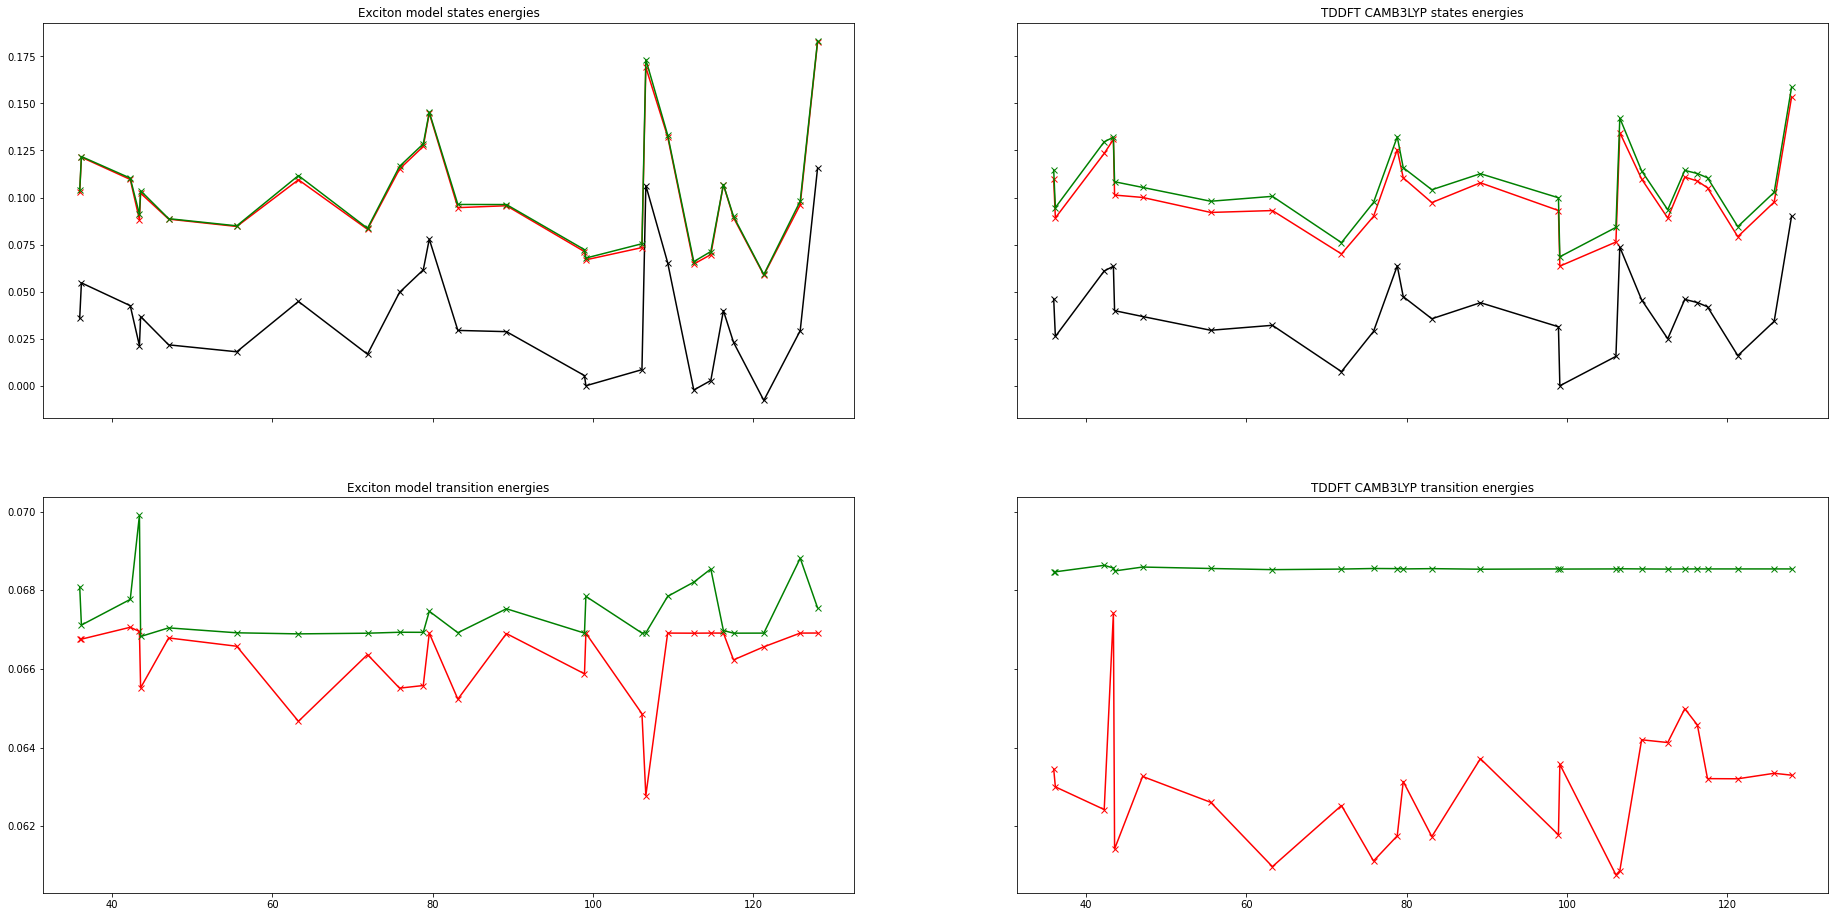

In [17]:
def one_chromophore(df, index):
    dfA = df.loc[df["monomer A"] == index]
    dfB = df.loc[df["monomer B"] == index]
    
    return pd.concat([dfA, dfB])

fig, axes = plt.subplots(2, 2, sharex = True, sharey = 'row')

ax = axes.ravel()

chromophore_20 = one_chromophore(LHII_dimers, 20)

chromophore_20 = chromophore_20.sort_values(by="distance")

exciton_c20_ground = get_values(chromophore_20["exciton states"], 0)
exciton_c20_excited1 = get_values(chromophore_20["exciton states"], 1)
exciton_c20_excited2 = get_values(chromophore_20["exciton states"], 2)

CAMB3LYP_c20_ground = get_values(chromophore_20["CAMB3LYP states"], 0)
CAMB3LYP_c20_excited1 = get_values(chromophore_20["CAMB3LYP states"], 1)
CAMB3LYP_c20_excited2 = get_values(chromophore_20["CAMB3LYP states"], 2)

exciton_c20_transition1 = get_values(chromophore_20["exciton transition"], 0)
exciton_c20_transition2 = get_values(chromophore_20["exciton transition"], 1)

CAMB3LYP_c20_transition1 = get_values(chromophore_20["CAMB3LYP transitions"], 0)
CAMB3LYP_c20_transition2 = get_values(chromophore_20["CAMB3LYP transitions"], 1)

min_index = np.argmin(CAMB3LYP_c20_ground)
exciton_origin  = exciton_c20_ground[min_index]
camb3lyp_origin = CAMB3LYP_c20_ground[min_index]

exciton_c20_ground_relative    = exciton_c20_ground - exciton_origin
exciton_c20_excited1_relative  = exciton_c20_excited1 - exciton_origin
exciton_c20_excited2_relative  = exciton_c20_excited2 - exciton_origin

CAMB3LYP_c20_ground_relative   = CAMB3LYP_c20_ground - camb3lyp_origin
CAMB3LYP_c20_excited1_relative = CAMB3LYP_c20_excited1 - camb3lyp_origin
CAMB3LYP_c20_excited2_relative = CAMB3LYP_c20_excited2 - camb3lyp_origin

distances = chromophore_20["distance"]

ax[0].plot(distances, exciton_c20_ground_relative, marker='x', color='black')
ax[0].plot(distances, exciton_c20_excited1_relative, marker='x', color='red')
ax[0].plot(distances, exciton_c20_excited2_relative, marker='x', color='green')

ax[1].plot(distances, CAMB3LYP_c20_ground_relative, marker='x', color='black')
ax[1].plot(distances, CAMB3LYP_c20_excited1_relative, marker='x', color='red')
ax[1].plot(distances, CAMB3LYP_c20_excited2_relative, marker='x', color='green')

ax[2].plot(distances, exciton_c20_transition1, marker='x', color='red')
ax[2].plot(distances, exciton_c20_transition2, marker='x', color='green')

ax[3].plot(distances, CAMB3LYP_c20_transition1, marker='x', color='red')
ax[3].plot(distances, CAMB3LYP_c20_transition2, marker='x', color='green')

ax[0].set_title("Exciton model states energies")
ax[1].set_title("TDDFT CAMB3LYP states energies")
ax[2].set_title("Exciton model transition energies")
ax[3].set_title("TDDFT CAMB3LYP transition energies")

fig.set_size_inches(32, 16)

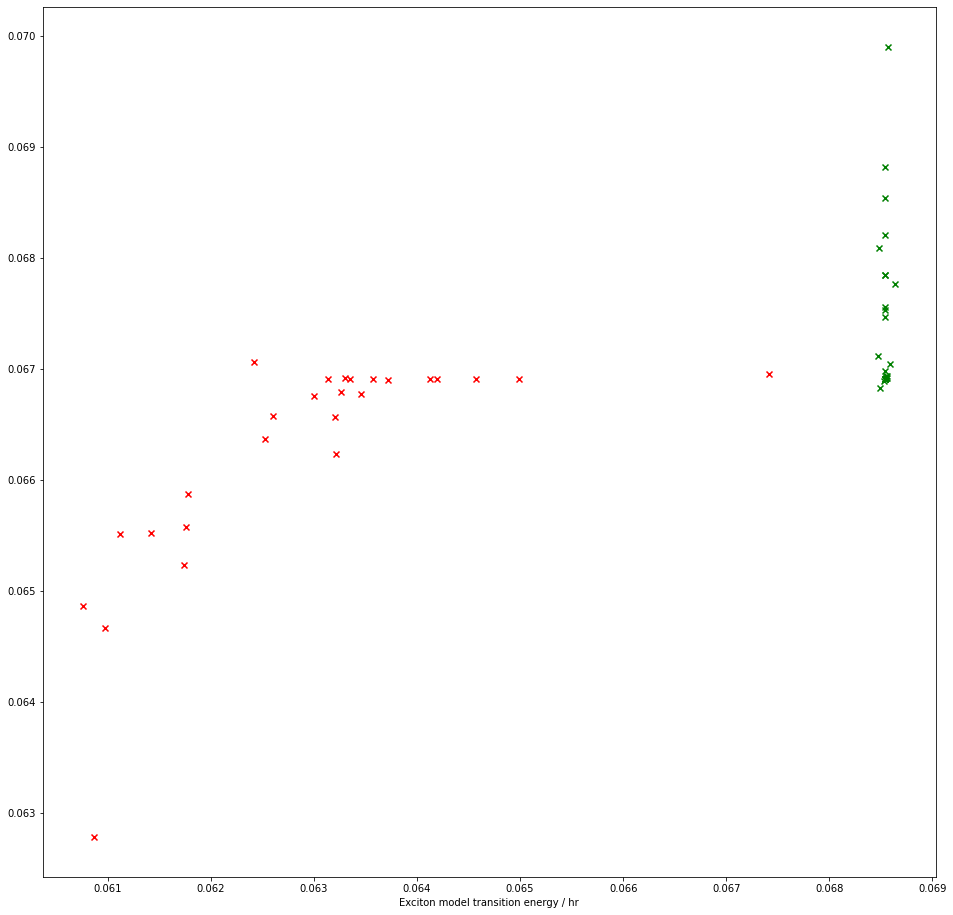

In [18]:
fig, ax = plt.subplots()

ax.scatter(CAMB3LYP_c20_transition1, exciton_c20_transition1, marker='x', color='red')
ax.scatter(CAMB3LYP_c20_transition2, exciton_c20_transition2, marker='x', color='green')

ax.set_xlabel("TDDFT CAMB3LYP transition energy / hr")
ax.set_xlabel("Exciton model transition energy / hr")

fig.set_size_inches(16,16)

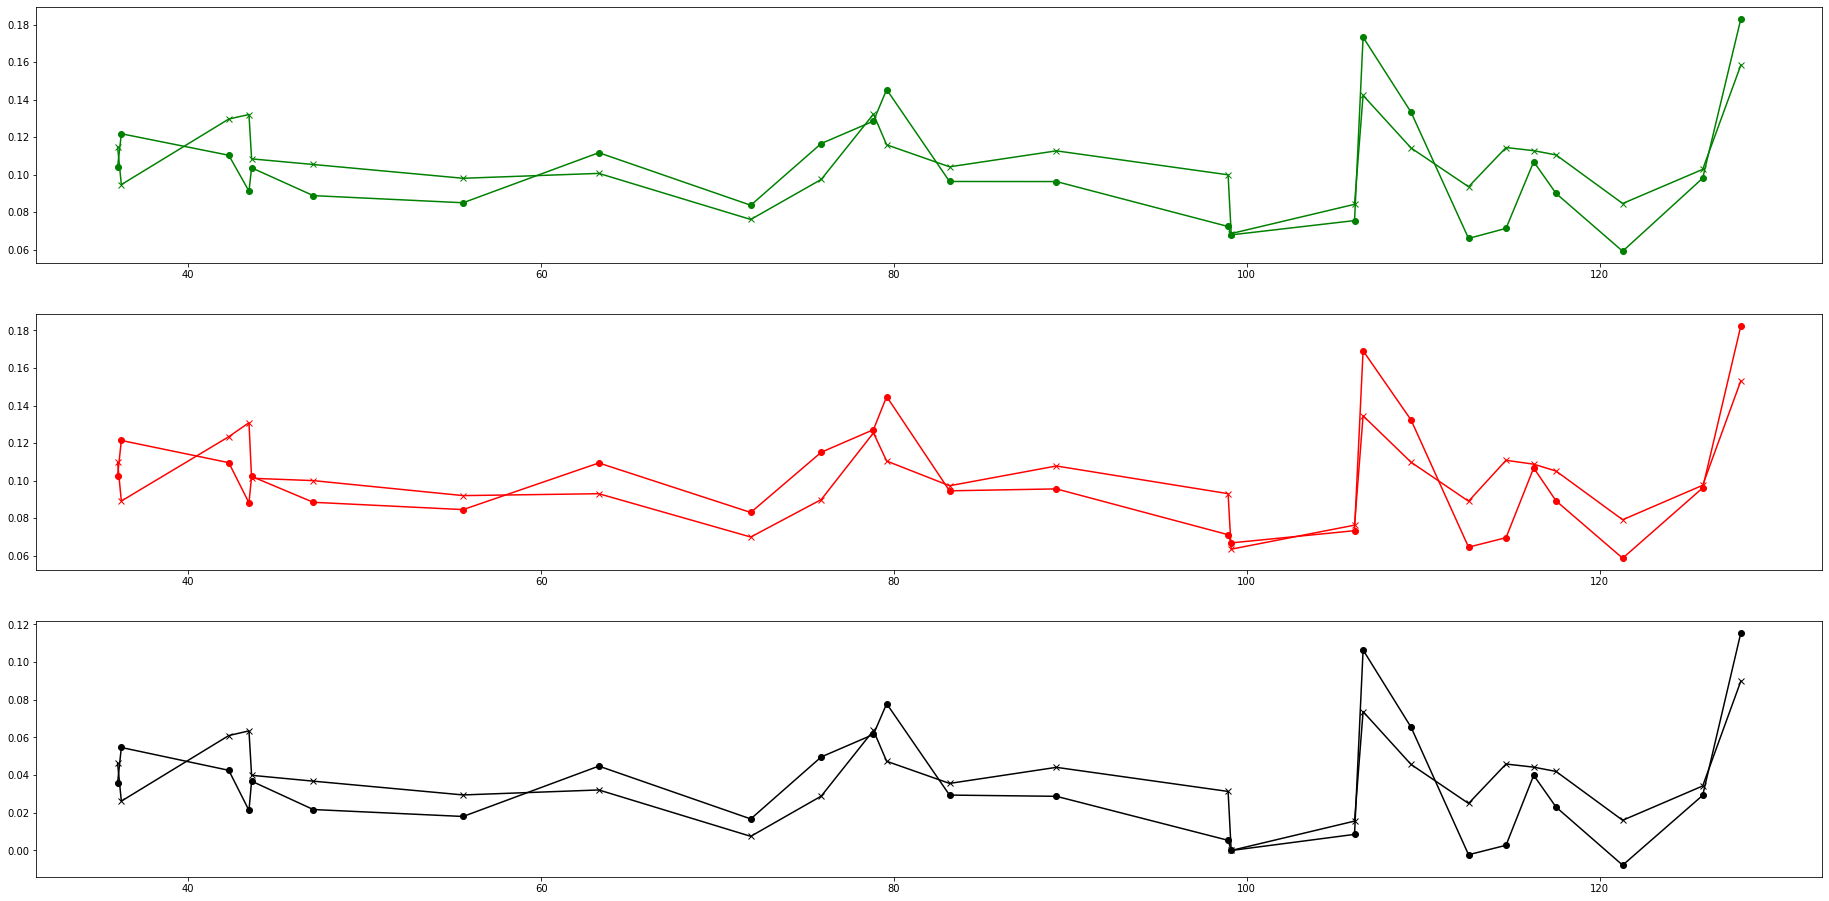

In [19]:
fig, ax = plt.subplots(3, 1)

ax[2].plot(distances, exciton_c20_ground_relative, color='black', marker='o')
ax[1].plot(distances, exciton_c20_excited1_relative, color='red', marker='o')
ax[0].plot(distances, exciton_c20_excited2_relative, color='green', marker='o')

ax[2].plot(distances, CAMB3LYP_c20_ground_relative,   color='black', marker='x')
ax[1].plot(distances, CAMB3LYP_c20_excited1_relative, color='red', marker='x')
ax[0].plot(distances, CAMB3LYP_c20_excited2_relative, color='green', marker='x')

fig.set_size_inches(32,16)

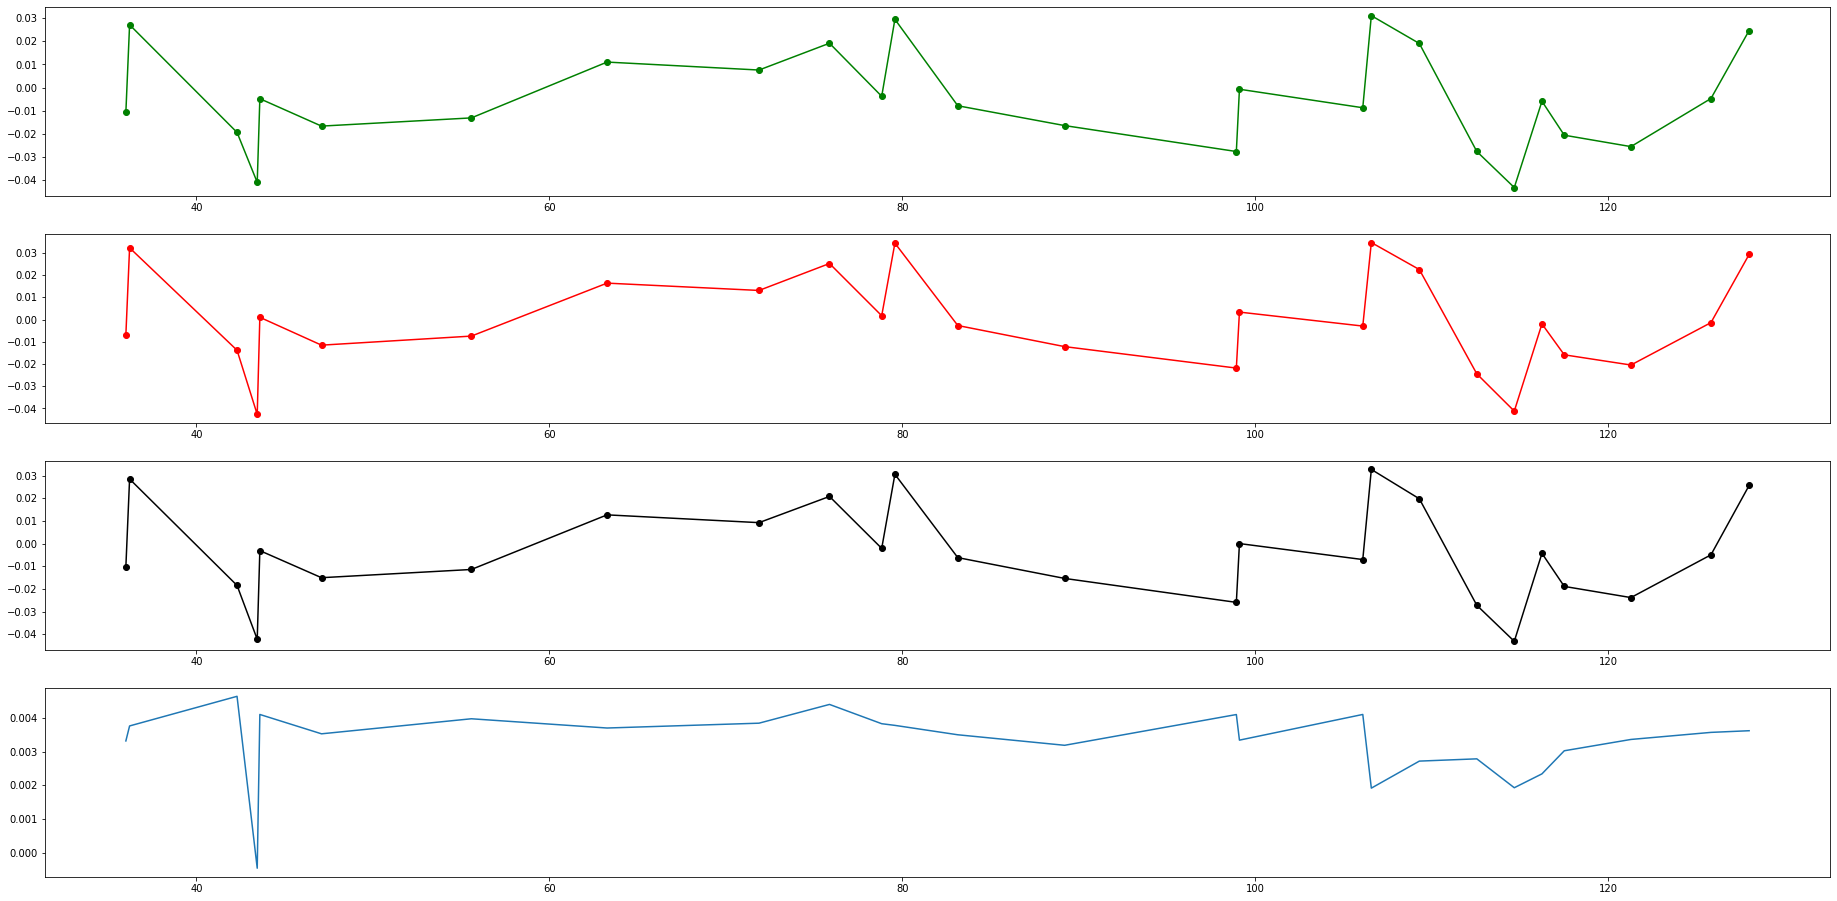

In [20]:
fig, ax = plt.subplots(4, 1)

ax[2].plot(distances, exciton_c20_ground_relative - CAMB3LYP_c20_ground_relative, color='black', marker='o')
ax[1].plot(distances, exciton_c20_excited1_relative - CAMB3LYP_c20_excited1_relative, color='red', marker='o')
ax[0].plot(distances, exciton_c20_excited2_relative - CAMB3LYP_c20_excited2_relative, color='green', marker='o')

ax[3].plot(distances, (exciton_c20_excited1_relative - CAMB3LYP_c20_excited1_relative) - (exciton_c20_ground_relative - CAMB3LYP_c20_ground_relative))

fig.set_size_inches(32,16)

## Ring interactions

In [21]:
def split_by_rings(df):
    B800_B800 = df.loc[(df["ring A"] == "B800") & (df["ring B"] == "B800")]

    B850_B850 = df.loc[(df["ring A"].isin(["B850a", "B850b"])) & (df["ring B"].isin(["B850a", "B850b"]))]

    B850_B800 = df.loc[(df["ring A"].isin(["B850a", "B850b"])) & (df["ring B"].isin(["B800"]))]
    B800_B850 = df.loc[(df["ring A"].isin(["B800"])) & (df["ring B"].isin(["B850a", "B850b"]))]
    
    return B800_B800, B850_B850, pd.concat([B850_B800, B800_B850])

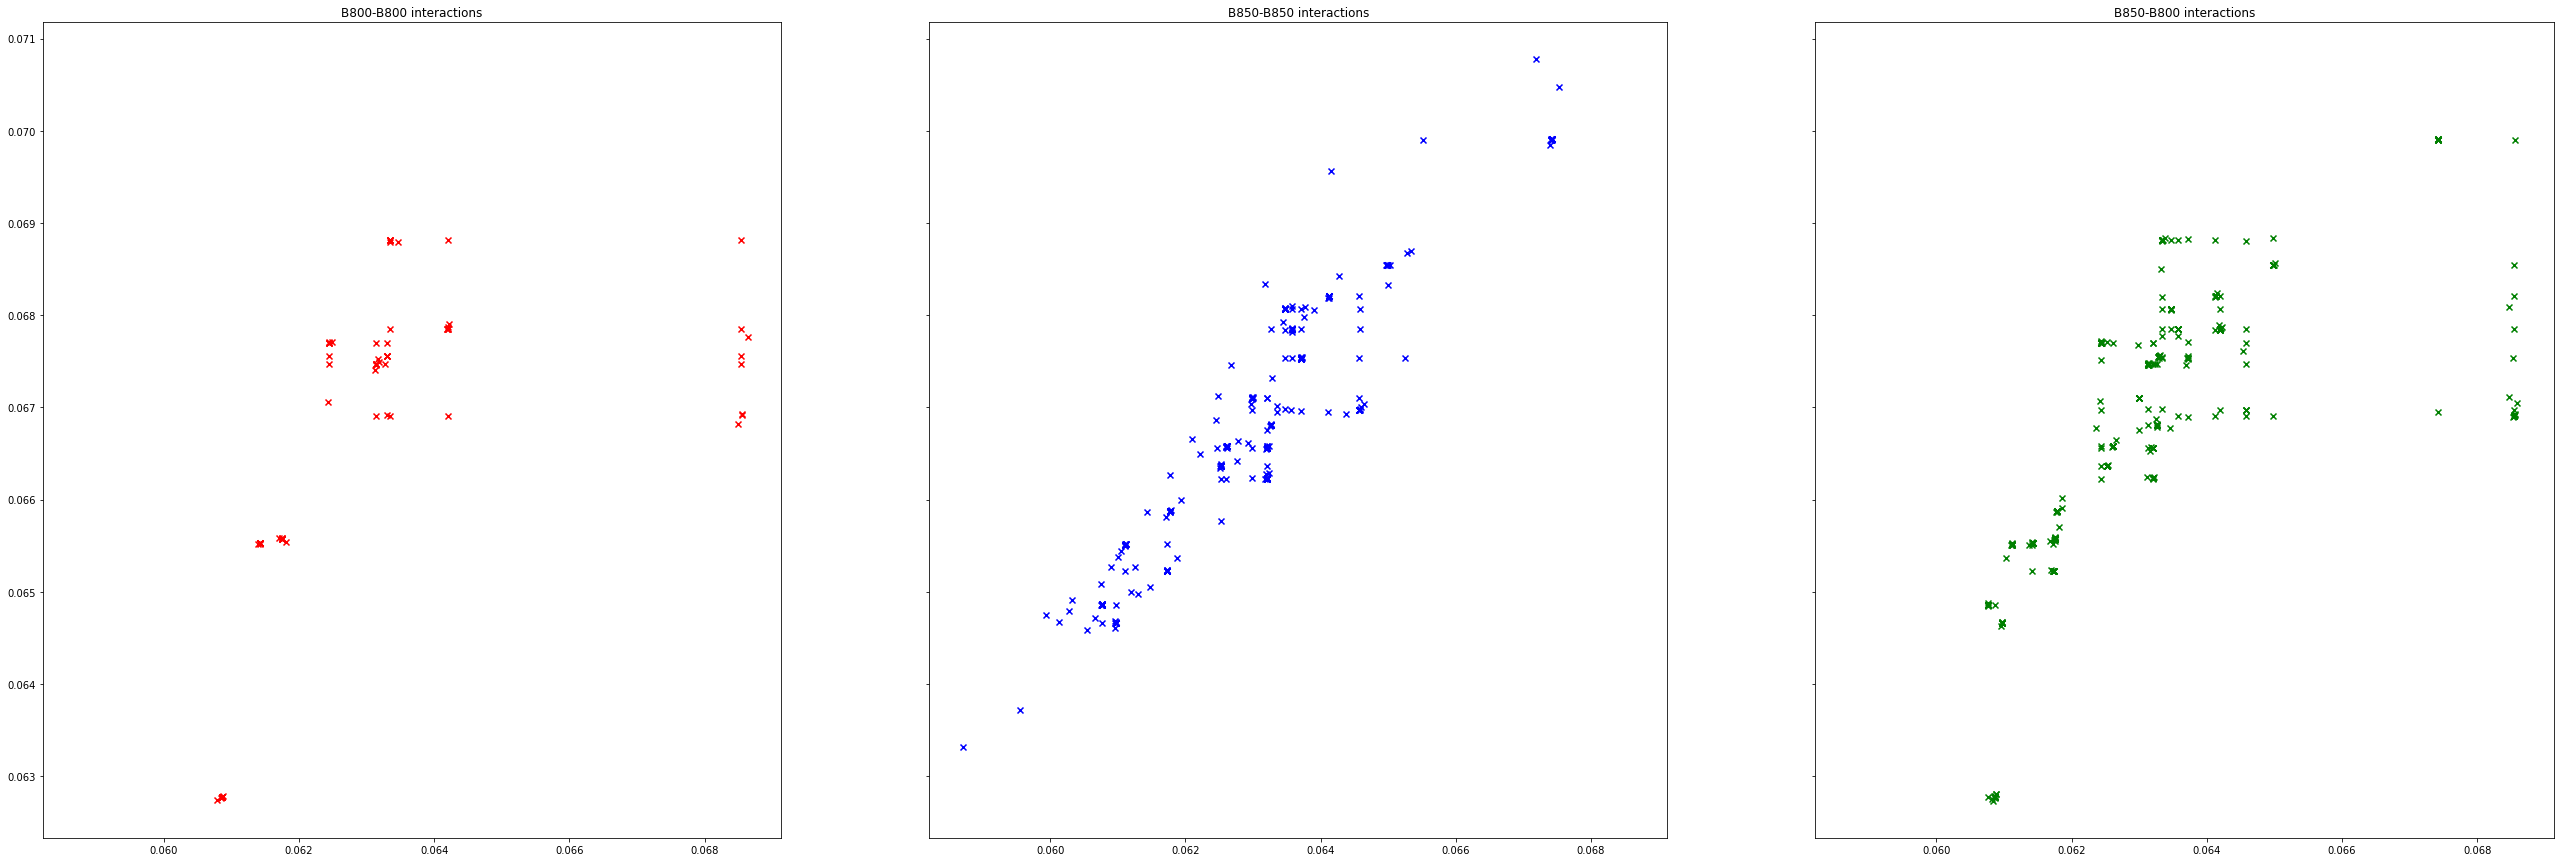

In [23]:
fig, ax = plt.subplots(1,3, sharex=True, sharey=True)

B800_B800, B850_B850, B850_B800 = split_by_rings(LHII_dimers)

B800_B800_camb3lyp = np.concatenate((get_values(B800_B800["CAMB3LYP transitions"], 0), get_values(B800_B800["CAMB3LYP transitions"], 1)))
B800_B800_excitons = np.concatenate((get_values(B800_B800["exciton transition"], 0), get_values(B800_B800["exciton transition"], 1)))

B850_B850_camb3lyp = np.concatenate((get_values(B850_B850["CAMB3LYP transitions"], 0), get_values(B850_B850["CAMB3LYP transitions"], 1)))
B850_B850_excitons = np.concatenate((get_values(B850_B850["exciton transition"], 0), get_values(B850_B850["exciton transition"], 1)))

B850_B800_camb3lyp = np.concatenate((get_values(B850_B800["CAMB3LYP transitions"], 0), get_values(B850_B800["CAMB3LYP transitions"], 1)))
B850_B800_excitons = np.concatenate((get_values(B850_B800["exciton transition"], 0), get_values(B850_B800["exciton transition"], 1)))

ax[0].scatter(B800_B800_camb3lyp, B800_B800_excitons, marker='x', color='red')
ax[1].scatter(B850_B850_camb3lyp, B850_B850_excitons, marker='x', color='blue')
ax[2].scatter(B850_B800_camb3lyp, B850_B800_excitons, marker='x', color='green')

ax[0].set_title("B800-B800 interactions")
ax[1].set_title("B850-B850 interactions")
ax[2].set_title("B850-B800 interactions")

fig.set_size_inches(45, 15)

# Exciton coupling

In [24]:
full_LHII_dimers

,monomer A,monomer B,ring A,ring B,frame,distance,charge centre distance,coupling,exciton states,exciton transition,CAMB3LYP states,CAMB3LYP transitions,CAMB3LYP present
0,1,2,B850a,B800,1,46.870688,44.068932,-17.104468,"[-253.18339612348677, -253.11817125138168, -253.11553296706649]","[0.06522487210509098, 0.0678631564202874]","[-4069.8069865, -4069.745258694742, -4069.7427817916796]","[0.06172780525809036, 0.06420470832077732]",True
1,1,3,B850a,B850b,1,18.775979,17.135812,-359.656912,"[-253.24540727582564, -253.1806535195335, -253.17584121308997]","[0.06475375629213431, 0.06956606273567445]","[-4069.85511007, -4069.795164605967, -4069.790960485635]","[0.05994546403345656, 0.06414958436537628]",True
2,1,4,B850a,B850a,1,33.518741,33.369960,73.699876,"[-253.24058991830222, -253.1760032741206, -253.17521988546045]","[0.06458664418161675, 0.0653700328417699]","[-4069.8374495, -4069.776897672457, -4069.775578372458]","[0.06055182754286806, 0.06187112754213307]",True
3,1,5,B850a,B800,1,77.018233,74.607113,5.103755,"[-253.13314913978334, -253.06791926394823, -253.06559174079965]","[0.06522987583511508, 0.06755739898369484]","[-4069.76267056, -4069.7009390798116, -4069.6993698845477]","[0.06173148018845043, 0.06330067545220018]",True
4,1,6,B850a,B850b,1,51.196162,49.509444,-16.901345,"[-253.22566438478674, -253.1604353636846, -253.15937706638957]","[0.0652290211021409, 0.06628731839717261]","[-4069.81064521, -4069.748917404742, -4069.747410683294]","[0.06172780525809036, 0.06323452670571893]",True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
70195,24,26,B850b,B800,49751,63.743820,62.927700,7.867909,"[-253.15941200283473, -253.09357081359204, -253.09254747311218]","[0.06584118924268978, 0.06686452972255097]","[None, None, None]","[None, None]",False
70196,24,27,B850b,B850b,49751,35.066438,34.658987,-4.111210,"[-253.2047664567592, -253.13976684782273, -253.13791264974262]","[0.06499960893646062, 0.06685380701657095]","[None, None, None]","[None, None]",False
70197,25,26,B850a,B800,49751,48.518499,46.609480,-20.362693,"[-253.16302621547163, -253.0976199755781, -253.09711880943593]","[0.06540623989351957, 0.06590740603570566]","[None, None, None]","[None, None]",False
70198,25,27,B850a,B850b,49751,18.137968,17.108029,358.107461,"[-253.21137337884463, -253.14744496593931, -253.1441449129409]","[0.06392841290531237, 0.06722846590372455]","[None, None, None]","[None, None]",False


In [32]:
set(full_LHII_dimers["frame"])

{1,
 251,
 501,
 751,
 1001,
 1251,
 1501,
 1751,
 2001,
 2251,
 2501,
 2751,
 3001,
 3251,
 3501,
 3751,
 4001,
 4251,
 4501,
 4751,
 5001,
 5251,
 5501,
 5751,
 6001,
 6251,
 6501,
 6751,
 7001,
 7251,
 7501,
 7751,
 8001,
 8251,
 8501,
 8751,
 9001,
 9251,
 9501,
 9751,
 10001,
 10251,
 10501,
 10751,
 11001,
 11251,
 11501,
 11751,
 12001,
 12251,
 12501,
 12751,
 13001,
 13251,
 13501,
 13751,
 14001,
 14251,
 14501,
 14751,
 15001,
 15251,
 15501,
 15751,
 16001,
 16251,
 16501,
 16751,
 17001,
 17251,
 17501,
 17751,
 18001,
 18251,
 18501,
 18751,
 19001,
 19251,
 19501,
 19751,
 20001,
 20251,
 20501,
 20751,
 21001,
 21251,
 21501,
 21751,
 22001,
 22251,
 22501,
 22751,
 23001,
 23251,
 23501,
 23751,
 24001,
 24251,
 24501,
 24751,
 25001,
 25251,
 25501,
 25751,
 26001,
 26251,
 26501,
 26751,
 27001,
 27251,
 27501,
 27751,
 28001,
 28251,
 28501,
 28751,
 29001,
 29251,
 29501,
 29751,
 30001,
 30251,
 30501,
 30751,
 31001,
 31251,
 31501,
 31751,
 32001,
 32251,
 32501

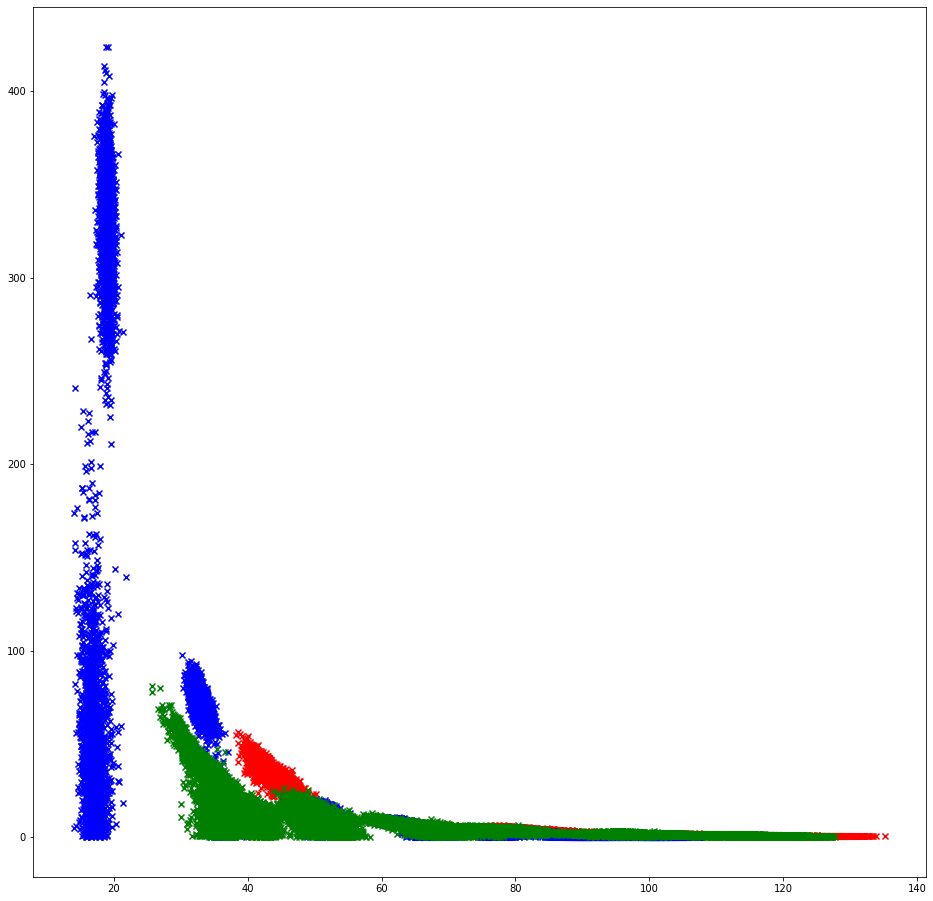

In [26]:
fig, ax = plt.subplots()

B800_B800, B850_B850, B850_B800 = split_by_rings(full_LHII_dimers)

ax.scatter(B800_B800["distance"], abs(B800_B800["coupling"]), marker='x', color='red')
ax.scatter(B850_B850["distance"], abs(B850_B850["coupling"]), marker='x', color='blue')
ax.scatter(B850_B800["distance"], abs(B850_B800["coupling"]), marker='x', color='green')

fig.set_size_inches(16, 16)